In [2]:
import pandas as pd 
import seaborn as sns 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split , RandomizedSearchCV , GridSearchCV , cross_val_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier , XGBRegressor
import numpy as np

In [3]:
df = pd.read_excel("premiums.xlsx")
df.shape

(50000, 13)

In [4]:
df.head(5)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [5]:
df.columns = df.columns.str.replace(" " , "_").str.lower()
df.head(5)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365


In [6]:
df.isnull().sum()

age                       0
gender                    0
region                    0
marital_status            0
number_of_dependants      0
bmi_category              0
smoking_status           11
employment_status         2
income_level             13
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

### Handling NA values

In [7]:
df.dropna(inplace = True)
df.isnull().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

### Checking Duplicate values

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49976.000000,49976.000000,49976.000000,49976.000000
mean,34.591764,1.711842,23.021150,15766.810189
std,15.000378,1.498195,24.221794,8419.995271
min,18.000000,-3.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8607.750000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22273.500000
max,356.000000,5.000000,930.000000,43471.000000


In [10]:
df[df.number_of_dependants < 0]["number_of_dependants"].unique()

array([-3, -1])

In [11]:
df["number_of_dependants"] = abs(df["number_of_dependants"])
df["number_of_dependants"].describe()

count    49976.000000
mean         1.717284
std          1.491953
min          0.000000
25%          0.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: number_of_dependants, dtype: float64

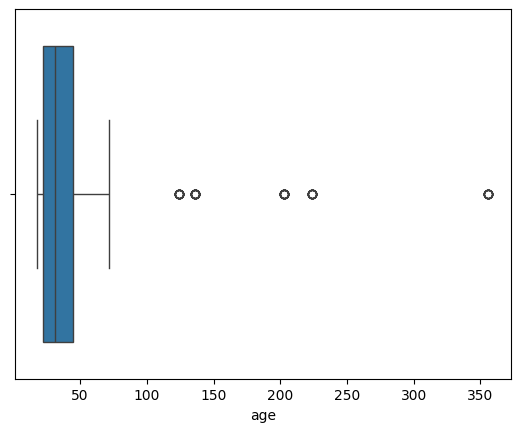

In [12]:
sns.boxplot(x = df['age'])
plt.show()

In [13]:
numeric_col = df.select_dtypes(['float64' , 'int64']).columns
numeric_col

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

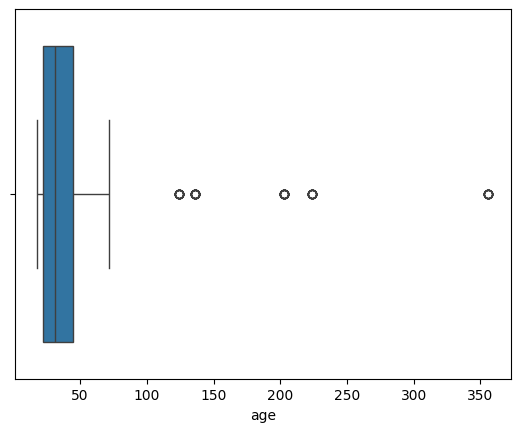

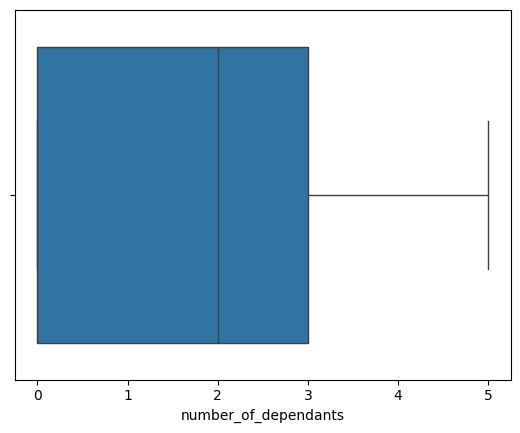

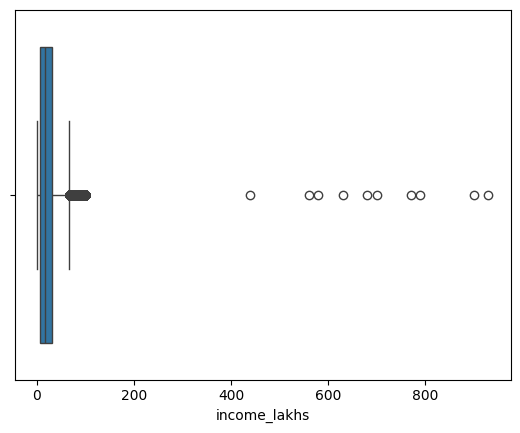

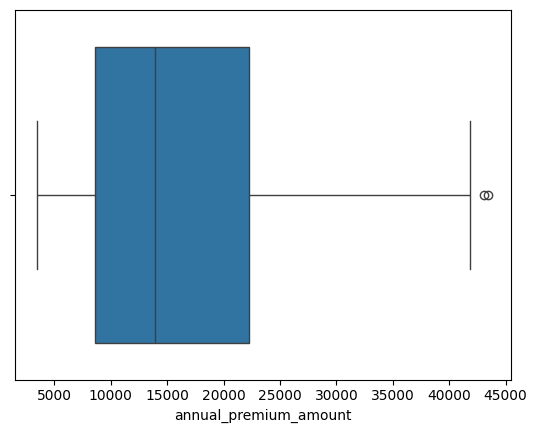

In [14]:
for col in numeric_col:
    sns.boxplot(x = df[col])
    plt.show()

In [15]:
df[df.age >100]["age"].unique()

array([224, 124, 136, 203, 356])

In [16]:
df1 = df[df.age <= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49918.000000,49918.000000,49918.000000,49918.000000
mean,34.401839,1.717617,23.025141,15766.589286
std,13.681600,1.492074,24.227912,8419.137327
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22272.000000
max,72.000000,5.000000,930.000000,43471.000000


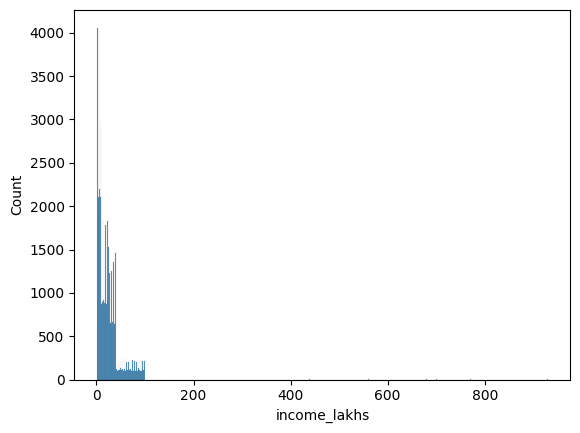

In [17]:
sns.histplot(df1.income_lakhs)
plt.show()

In [18]:
df1.income_lakhs.quantile([0.25 , 0.75])


0.25     7.0
0.75    31.0
Name: income_lakhs, dtype: float64

In [19]:
def get_iqr_bounds(col):
    Q1 , Q3 = col.quantile([0.25 , 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return lower_bound , upper_bound

In [20]:
get_iqr_bounds(df1.income_lakhs)

(-29.0, 67.0)

In [21]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
quantile_threshold

np.float64(100.0)

In [22]:
df2 = df1[df1.income_lakhs <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,49908.000000,49908.000000,49908.000000,49908.000000
mean,34.401579,1.717640,22.889897,15765.739641
std,13.681604,1.492032,22.170699,8418.674061
min,18.000000,0.000000,1.000000,3501.000000
25%,22.000000,0.000000,7.000000,8608.000000
50%,31.000000,2.000000,17.000000,13928.000000
75%,45.000000,3.000000,31.000000,22270.500000
max,72.000000,5.000000,100.000000,43471.000000


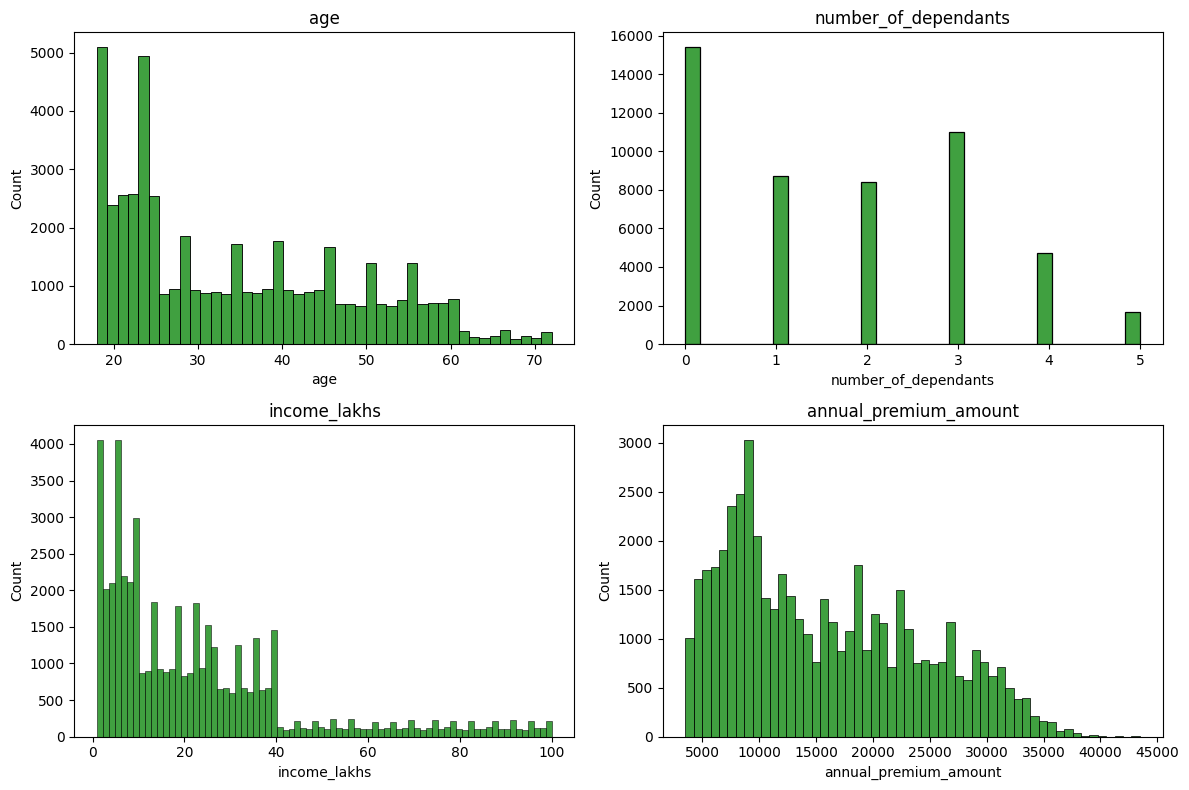

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(numeric_col[:4]):
    sns.histplot(
        df2[col],
        color="green",
        edgecolor="black",
        ax=axes[i]
    )
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

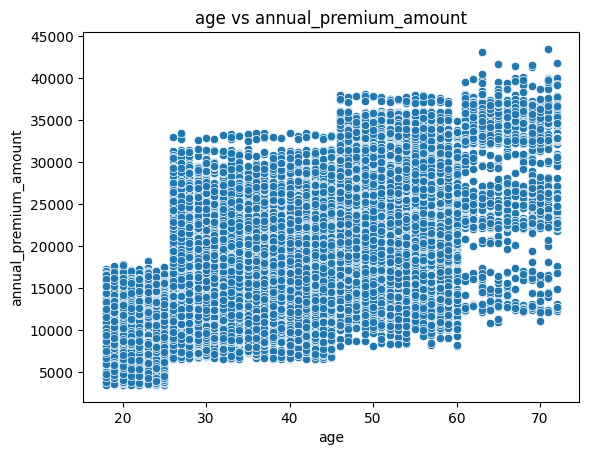

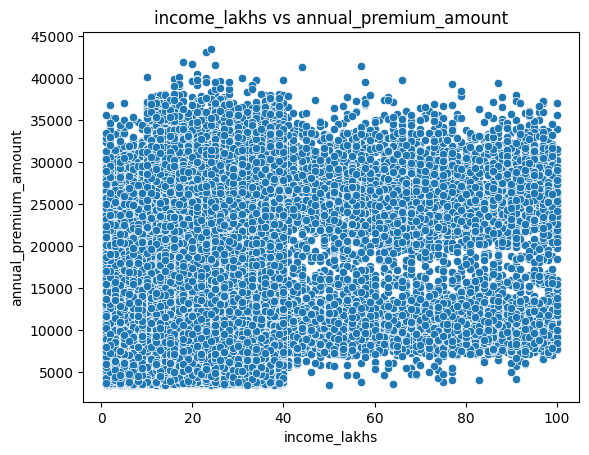

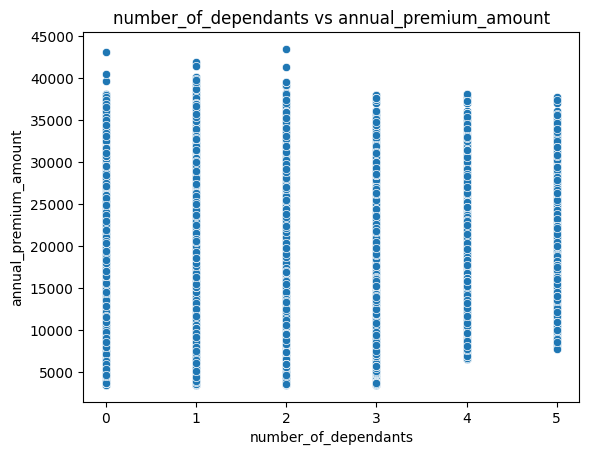

In [24]:
numeric_features = ["age" , "income_lakhs" , "number_of_dependants"]

for num in numeric_features:
    sns.scatterplot( x = df2[num]  , y= df2["annual_premium_amount"])
    plt.title(f"{num} vs annual_premium_amount")
    plt.xlabel(num)
    plt.ylabel("annual_premium_amount")
    plt.show()



In [25]:
categorical_col = df2.select_dtypes(['string' , 'object' ,'category']).columns
categorical_col

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [26]:
category_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan']

for cat in category_col:
    print(cat , ":" , df2[cat].unique())

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [27]:
df2["smoking_status"].replace({
    "Smoking=0": "No Smoking",
    "Does Not Smoke": "No Smoking",
    "Not Smoking": "No Smoking"
}, inplace=True)

df2["smoking_status"].unique()

C:\Users\sehaj\AppData\Local\Temp\ipykernel_6752\3325360402.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2["smoking_status"].replace({


array(['No Smoking', 'Regular', 'Occasional'], dtype=object)

In [28]:
pct_count = df2["gender"].value_counts(normalize = True)
pct_count

gender
Male      0.549631
Female    0.450369
Name: proportion, dtype: float64

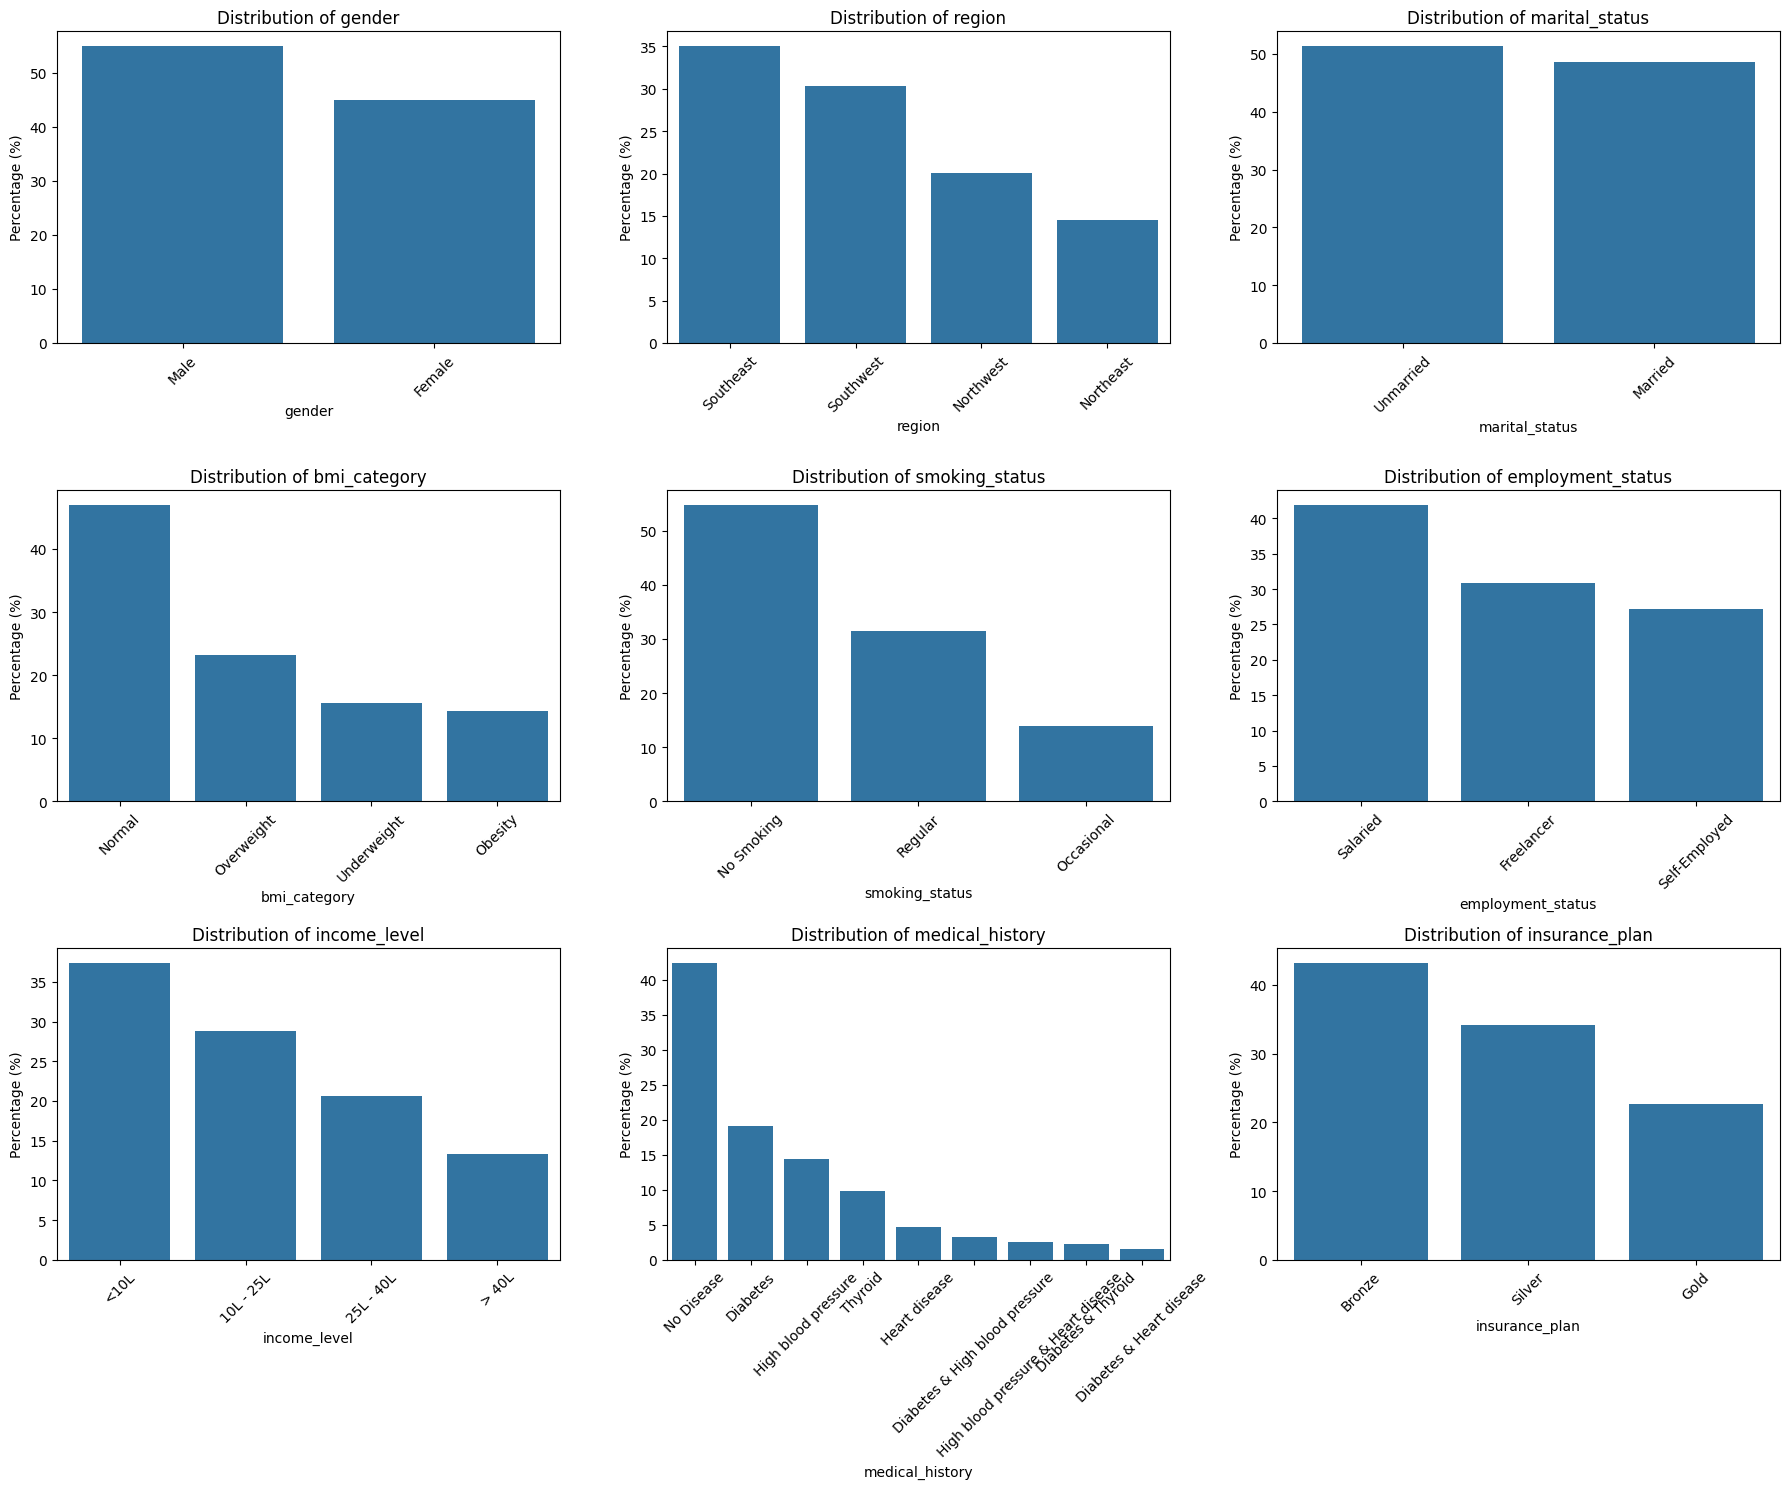

In [29]:






fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()


for i, col in enumerate(category_col[:9]):
    overall_pct = df2[col].value_counts(normalize=True) * 100
    
    
    sns.barplot(
    x=overall_pct.index,
    y=overall_pct.values,
    ax=axes[i]
    )
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Percentage (%)")
    axes[i].tick_params(axis='x', rotation=45)
    
    
plt.tight_layout()
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         5307  3880    5182
25L - 40L         3683  2840    3750
<10L             12226   931    5486
> 40L              329  3653    2641


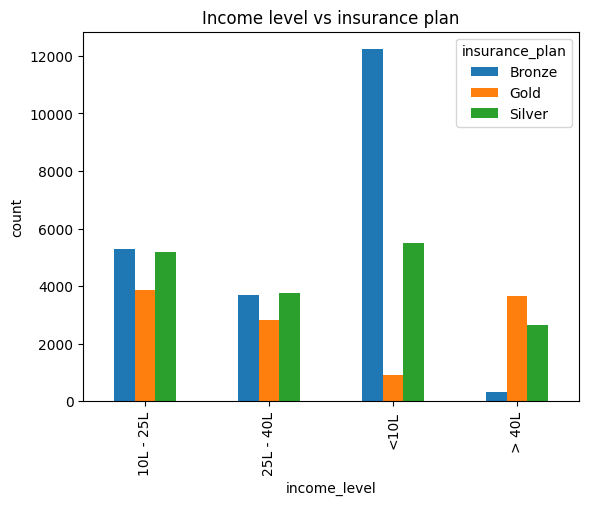

In [30]:
crosstab = pd.crosstab(df2['income_level'] , df2['insurance_plan'])
print(crosstab)
crosstab.plot(kind = "bar")
plt.title("Income level vs insurance plan")
plt.ylabel("count")
plt.show()

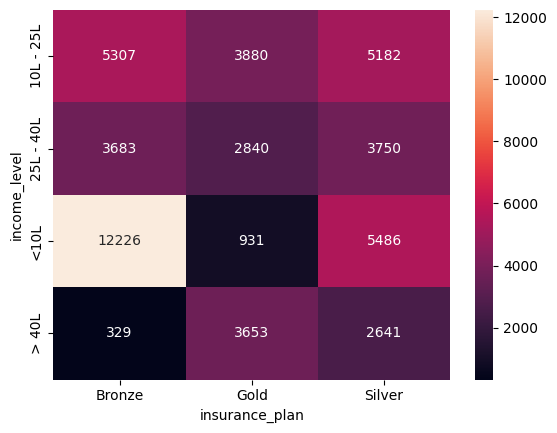

In [31]:
sns.heatmap(crosstab , fmt = "d" , annot = True)
plt.show()

### Feature Engineering

In [32]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339


In [33]:
df2.medical_history.unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [34]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

In [35]:
df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(15)


C:\Users\sehaj\AppData\Local\Temp\ipykernel_6752\1859339688.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
C:\Users\sehaj\AppData\Local\Temp\ipykernel_6752\1859339688.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, 

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,diabetes,none,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,diabetes,none,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,high blood pressure,none,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,no disease,none,0,0.000000
4,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
5,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,diabetes,none,6,0.428571
6,33,Male,Southeast,Married,3,Normal,Regular,Self-Employed,<10L,4,Diabetes & High blood pressure,Silver,20653,diabetes,high blood pressure,12,0.857143
7,43,Male,Northeast,Married,3,Overweight,Regular,Salaried,> 40L,46,Thyroid,Gold,26926,thyroid,none,5,0.357143
8,59,Female,Southeast,Unmarried,0,Overweight,No Smoking,Freelancer,10L - 25L,21,No Disease,Gold,26101,no disease,none,0,0.000000
9,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


### Encode Text columns


In [36]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2['insurance_plan']

0        1
1        1
2        2
3        3
4        2
        ..
49995    1
49996    3
49997    1
49998    1
49999    2
Name: insurance_plan, Length: 49908, dtype: int64

In [37]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
df2['income_level'].unique()

array([1, 2, 4, 3])

In [38]:
numeric_col = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2 , columns = numeric_col , drop_first = True , dtype = int)
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,diabetes,none,6,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,diabetes,none,6,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,high blood pressure,none,6,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,no disease,none,0,...,1,0,0,0,0,0,0,0,1,0
4,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,...,0,0,1,0,1,0,0,1,0,1


In [39]:
df4 = df3.drop(["medical_history" , "disease1" , "disease2" , "total_risk_score"] , axis =  1)
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0.428571,0,0,0,0,0,0,0,0,0,0,0,1


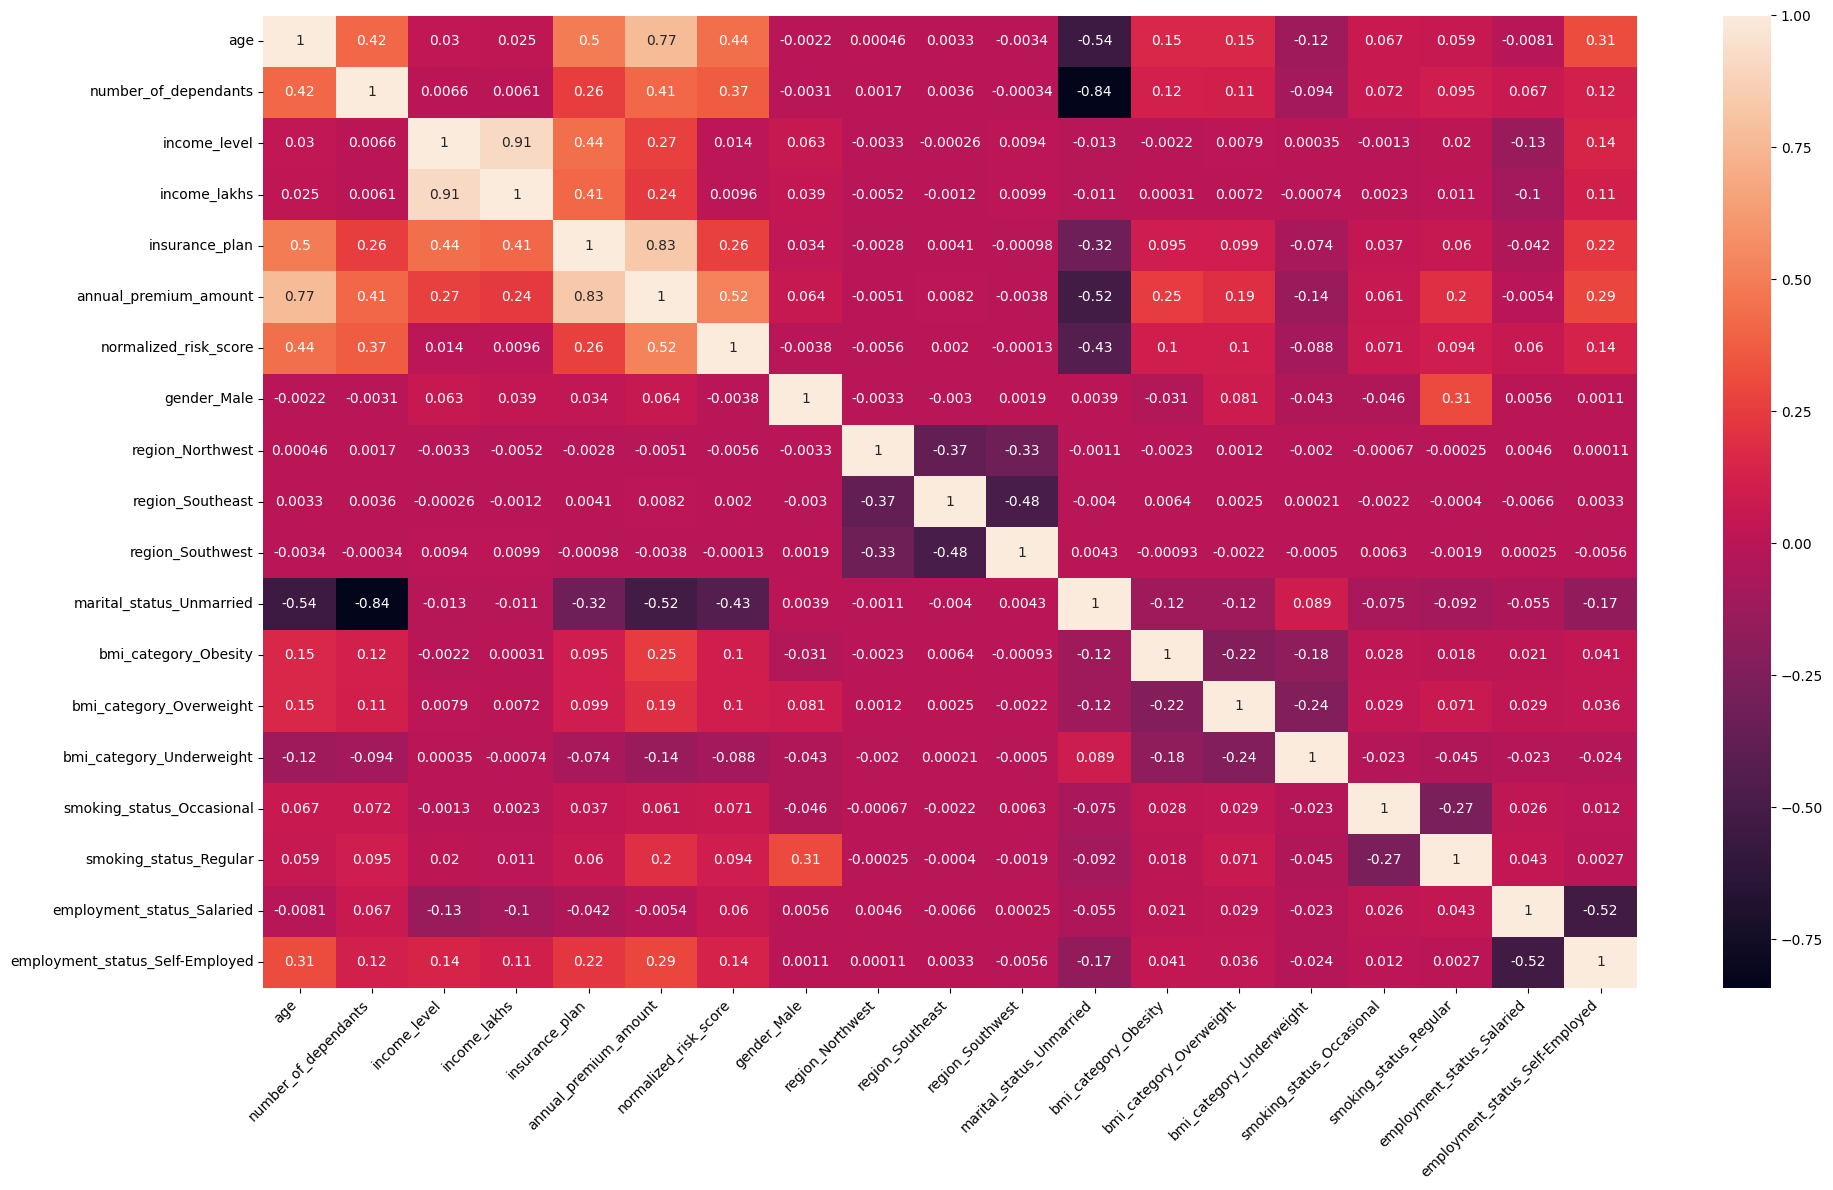

In [40]:
corr_mat = df4.corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr_mat , annot = True)
plt.xticks(rotation = 45 , ha ='right')
plt.yticks(rotation = 0)
plt.tight_layout()
plt.show()

In [41]:
x = df4.drop("annual_premium_amount" , axis =1)
y = df4["annual_premium_amount"]

scaler = MinMaxScaler()
cols_to_scale = ["age" , "number_of_dependants" , "income_level" , "income_lakhs" , "insurance_plan"]
x[cols_to_scale] = scaler.fit_transform(x[cols_to_scale])
x.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.00000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000,49908.000000
mean,0.303733,0.343528,0.365900,0.221110,0.397401,0.291831,0.549631,0.20093,0.350385,0.303038,0.513545,0.143183,0.231245,0.155326,0.138274,0.313857,0.419412,0.272041
std,0.253363,0.298406,0.349711,0.223946,0.392459,0.287420,0.497536,0.40070,0.477095,0.459576,0.499822,0.350263,0.421633,0.362219,0.345191,0.464064,0.493468,0.445015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074074,0.000000,0.000000,0.060606,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.240741,0.400000,0.333333,0.161616,0.500000,0.357143,1.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.500000,0.600000,0.666667,0.303030,0.500000,0.428571,1.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df


In [43]:
calculate_vif(x)

,Column,VIF
0,age,4.567634
1,number_of_dependants,4.534650
2,income_level,12.450675
3,income_lakhs,11.183367
4,insurance_plan,3.584752
5,normalized_risk_score,2.687610
6,gender_Male,2.421496
7,region_Northwest,2.102556
8,region_Southeast,2.922414
9,region_Southwest,2.670666


In [44]:
calculate_vif(x.drop("income_level" , axis = 1))

,Column,VIF
0,age,4.545825
1,number_of_dependants,4.526598
2,income_lakhs,2.480563
3,insurance_plan,3.445682
4,normalized_risk_score,2.687326
5,gender_Male,2.409980
6,region_Northwest,2.100789
7,region_Southeast,2.919775
8,region_Southwest,2.668314
9,marital_status_Unmarried,3.393718


In [45]:
x_reduced =  x.drop("income_level" , axis =1)
x_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.148148,0.0,0.050505,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.203704,0.4,0.050505,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.574074,0.4,0.191919,0.5,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.222222,0.6,0.767677,1.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.000000,0.0,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1


### Model Training

In [46]:
x_train , x_test , y_train, y_test = train_test_split(x_reduced , y , test_size = 0.3 , random_state = 10)

print("x_train:" , x_train.shape)
print("x_test:" , x_test.shape)
print("y_train:" , y_train.shape)
print("y_test:" , y_test.shape)


x_train: (34935, 17)
x_test: (14973, 17)
y_train: (34935,)
y_test: (14973,)


In [47]:
model_lr = LinearRegression()
model_lr.fit(x_train , y_train)

test_score = model_lr.score(x_test , y_test)
train_score = model_lr.score(x_train , y_train)

print("Test score of the linear regression :" , test_score)
print("Train score of the linear regression : " , train_score)

Test score of the linear regression : 0.9280547230217837
Train score of the linear regression :  0.9282143576916762


In [48]:
y_pred = model_lr.predict(x_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Linear Regression ==> MSE:  5165611.913027982 RMSE:  2272.798256121291


In [49]:
x_test.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
3598,0.481481,0.4,0.343434,0.5,0.428571,1,0,1,0,1,0,1,0,0,1,1,0
35794,0.648148,0.6,0.202020,1.0,0.000000,1,0,0,0,0,1,0,0,1,0,1,0


In [50]:
model_lr.intercept_

np.float64(4824.300272127104)

In [51]:
model_lr.coef_

array([11160.92646188,  -676.44399066,  -514.22981577, 12557.01293645,
        4810.35770228,   168.64666183,   -35.7192924 ,    39.96512973,
         -24.65292857,  -935.76061134,  3387.91145477,  1599.36226775,
         391.1713038 ,   735.91227798,  2234.8047119 ,   155.9846743 ,
         415.90397305])

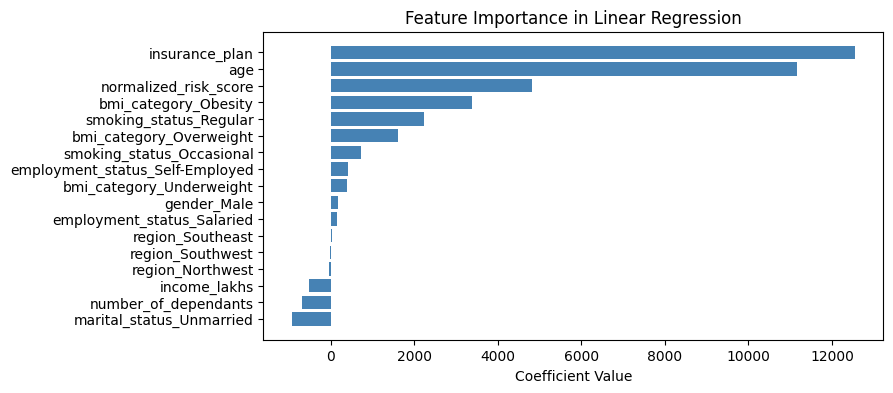

In [52]:
feature_importance = model_lr.coef_
coef_df = pd.DataFrame(feature_importance , index = x_test.columns , columns = ["coefficients"])
coef_df = coef_df.sort_values(by ="coefficients" , ascending= True)
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [53]:
model_ridge = Ridge()
model_ridge.fit(x_train , y_train)
test_score_ridge = model_ridge.score(x_test , y_test)
train_score_ridge = model_ridge.score(x_train , y_train)
print("Test score of the Ridge model is :" , test_score_ridge)
print("Train score of the Ridge model is :" , train_score_ridge)

Test score of the Ridge model is : 0.9280541644640345
Train score of the Ridge model is : 0.9282143198366275


In [54]:
model_xgb = XGBRegressor()
model_xgb.fit(x_train , y_train)
test_score_xgb = model_xgb.score(x_test , y_test)
train_score_xgb = model_xgb.score(x_train , y_train)
print("Test score of the xgb model is :" , test_score_xgb)
print("Train score of the xgb model is :" , train_score_xgb)

Test score of the xgb model is : 0.9809534549713135
Train score of the xgb model is : 0.9860964417457581


In [55]:
y_pred = model_xgb.predict(x_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  1367525.6922808294 RMSE:  1169.412541527082


In [56]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)
random_search.best_score_

np.float64(0.9809474547704061)

In [57]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [58]:
best_model = random_search.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)

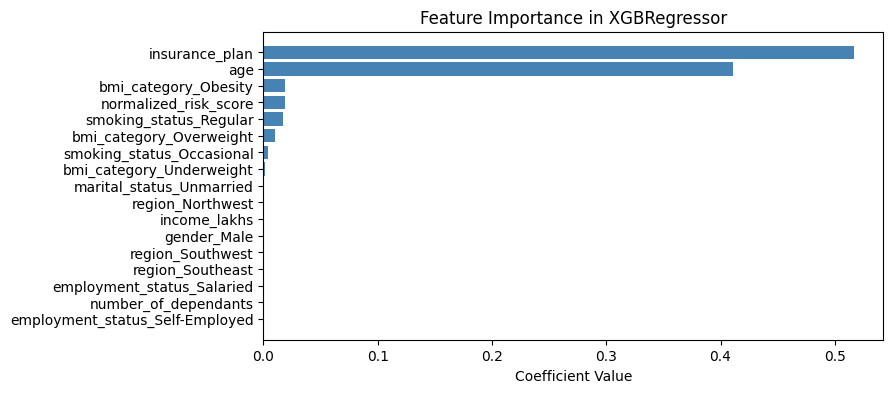

In [59]:
feature_importance = best_model.feature_importances_
coef_df = pd.DataFrame(feature_importance , index = x_test.columns , columns = ["coefficients"])
coef_df = coef_df.sort_values(by ="coefficients" , ascending= True)
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBRegressor')
plt.show()

### Error Analysis

In [61]:
y_pred = best_model.predict(x_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

results_df = pd.DataFrame({
    'actual': y_test ,
    'predicted' : y_pred ,
    'diff' : residuals ,
    'diff_pct' : residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
3598,20554,20334.953125,-219.046875,-1.065714
35794,29647,29378.779297,-268.220703,-0.904714
43608,20560,20618.185547,58.185547,0.283004
42730,5018,7352.829590,2334.829590,46.529087
18936,8929,8203.291992,-725.708008,-8.127540


<Axes: xlabel='diff_pct', ylabel='Count'>

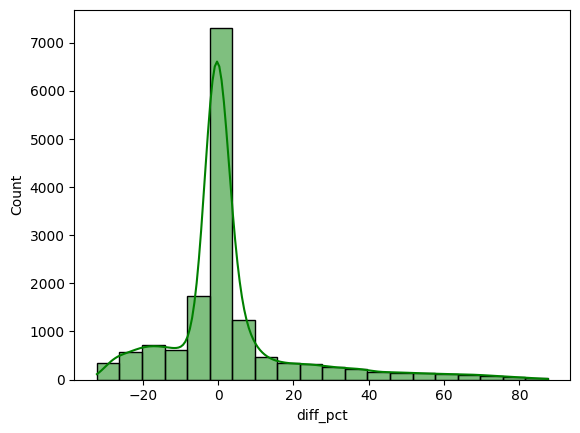

In [62]:
sns.histplot(results_df['diff_pct'] , bins = 20 , color = 'green' , edgecolor = 'black' , kde = True)


In [66]:
extreme_error_threshold = 10
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df 


,actual,predicted,diff,diff_pct
42730,5018,7352.829590,2334.829590,46.529087
20029,5140,6670.849121,1530.849121,29.783057
4294,9631,7053.477539,-2577.522461,-26.762771
44419,4687,6670.849121,1983.849121,42.326629
6707,8826,10047.326172,1221.326172,13.837822
...,...,...,...,...
8767,8113,6565.852051,-1547.147949,-19.069986
25179,9944,7058.687988,-2885.312012,-29.015608
21592,8332,10615.658203,2283.658203,27.408284
49274,5571,6820.886230,1249.886230,22.435581


In [67]:
results_df.shape

(14973, 4)

In [68]:
extreme_results_df.shape

(4487, 4)

In [70]:
extreme_error_pct = extreme_results_df.shape[0] *100 / results_df.shape[0]
extreme_error_pct

29.967274427302478

In [71]:
results_df[np.abs(results_df['diff_pct']) > 50].sort_values('diff_pct' , ascending = False)

,actual,predicted,diff,diff_pct
36269,3501,6565.852051,3064.852051,87.542189
48801,3516,6565.852051,3049.852051,86.742095
42342,3521,6565.852051,3044.852051,86.476911
18564,3523,6565.852051,3042.852051,86.371049
7988,3527,6565.852051,3038.852051,86.159684
...,...,...,...,...
32671,4656,6994.980957,2338.980957,50.235845
14798,4371,6565.852051,2194.852051,50.213957
13736,4371,6565.852051,2194.852051,50.213957
10107,4710,7073.240723,2363.240723,50.174962


In [72]:
x_test.index

Index([ 3598, 35794, 43608, 42730, 18936, 45416, 20029,  4294, 39145,  3152,
       ...
        4554,  9086,  8767,   603, 25179,  5621,  6069, 21592, 49274, 27977],
      dtype='int64', length=14973)

In [73]:
extreme_results_df.index

Index([42730, 20029,  4294, 44419,  6707, 11728, 15740, 35065,  9654, 22679,
       ...
       36158, 30386, 21184, 45020,  8249,  8767, 25179, 21592, 49274, 27977],
      dtype='int64', length=4487)

In [77]:
extreme_error_df = x_test.loc[extreme_results_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
42730,0.092593,0.2,0.131313,0.0,0.428571,1,0,0,0,1,0,1,0,0,0,0,0
20029,0.018519,0.2,0.030303,0.0,0.000000,0,1,0,0,1,0,0,1,0,0,1,0
4294,0.000000,0.2,0.020202,0.0,0.000000,1,0,0,1,1,0,1,0,0,0,0,0
44419,0.055556,0.0,0.242424,0.0,0.000000,0,0,0,0,1,0,0,1,0,0,0,0
6707,0.111111,0.2,0.070707,0.5,0.000000,1,0,0,0,1,0,0,1,0,0,0,0


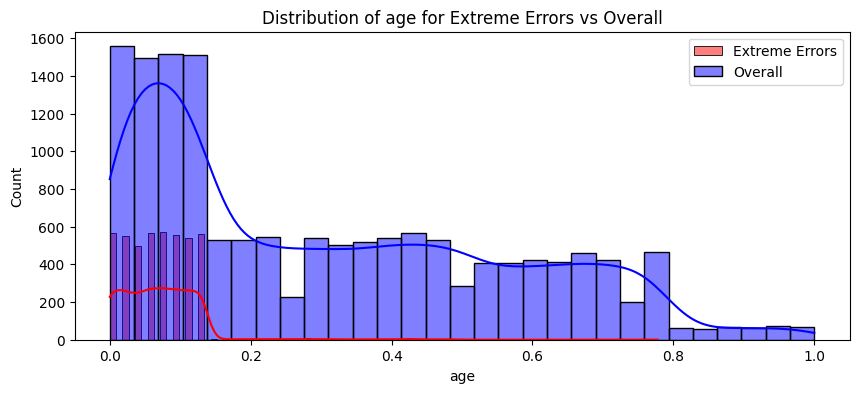

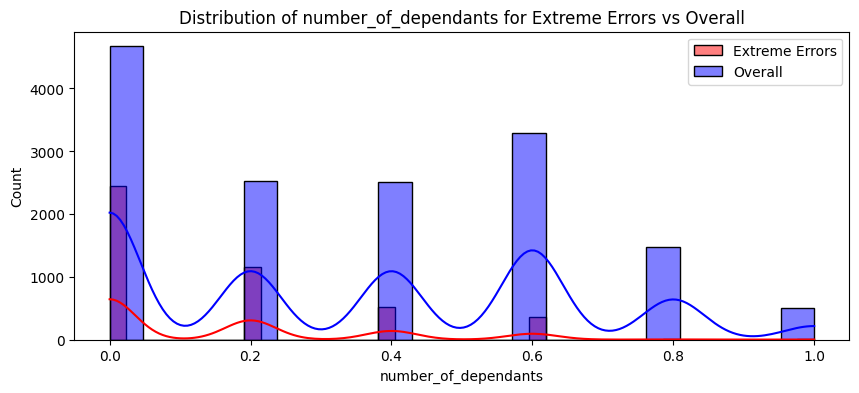

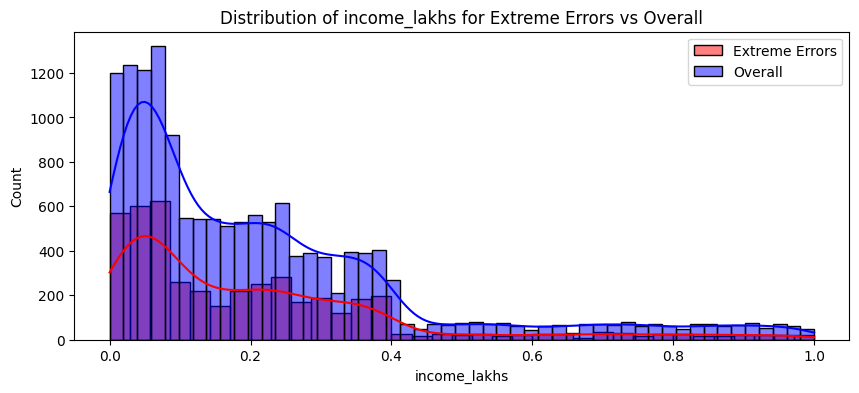

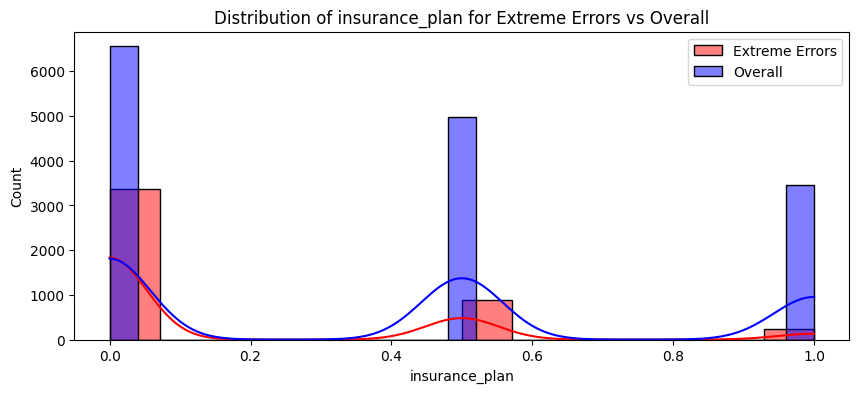

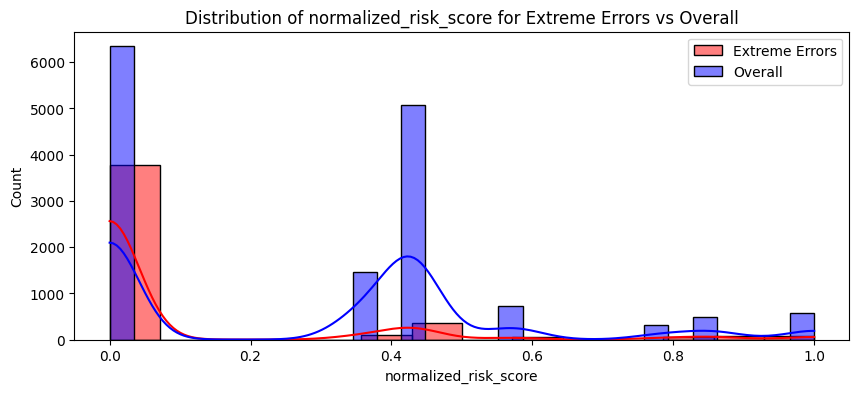

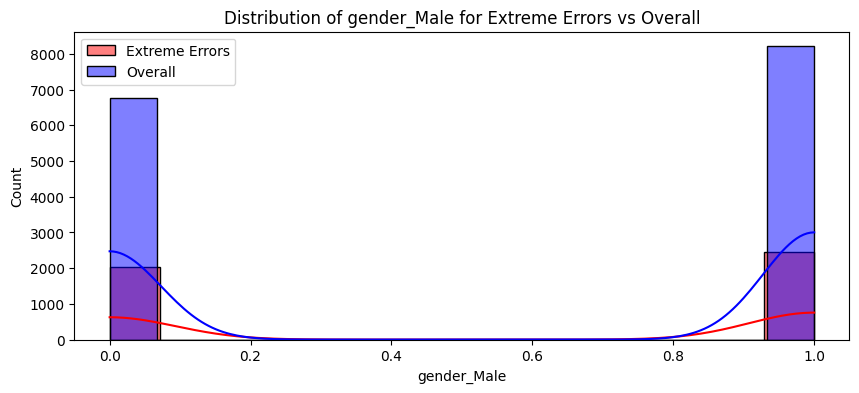

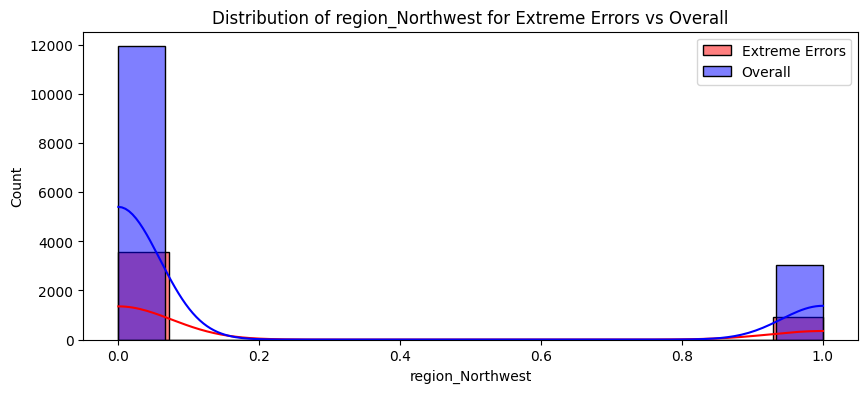

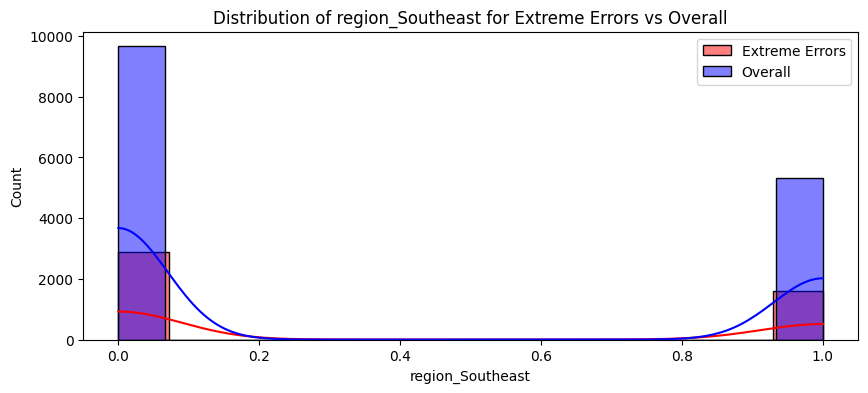

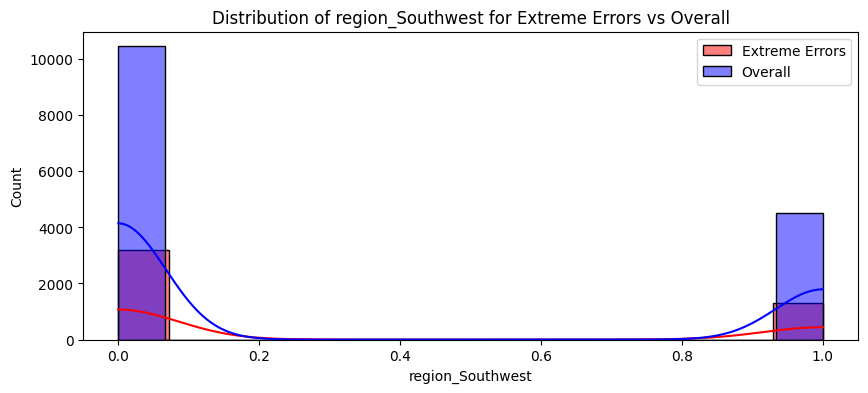

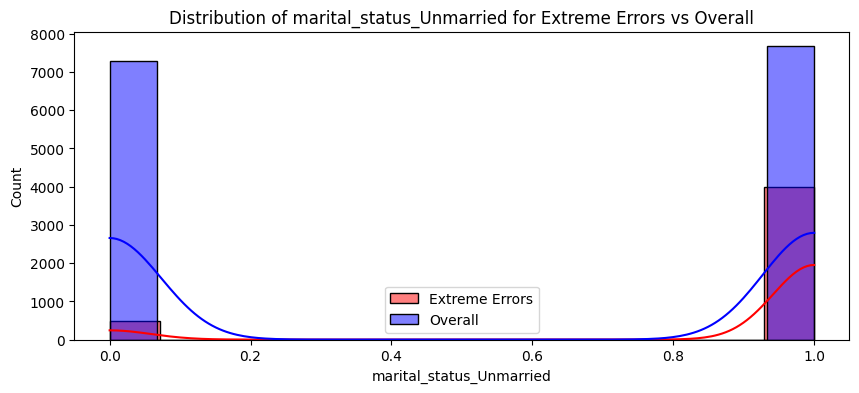

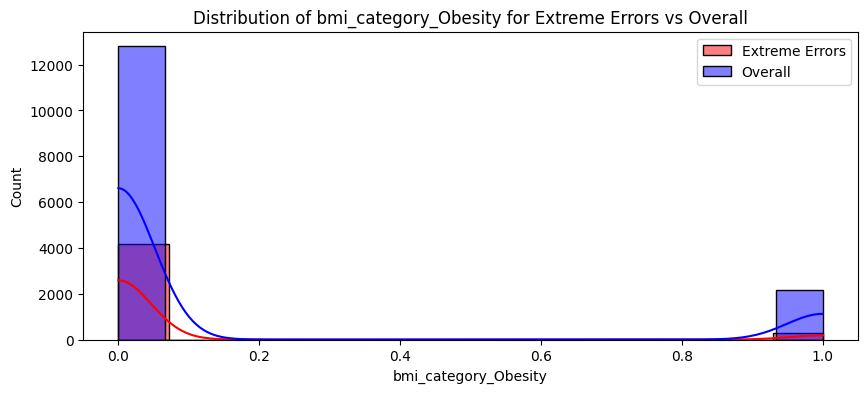

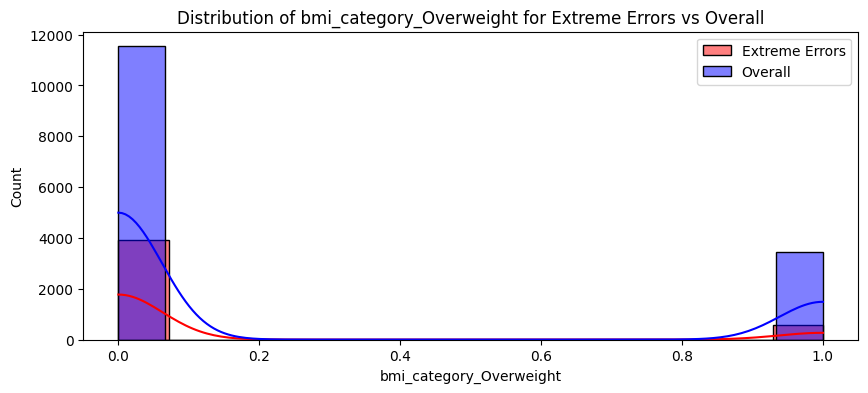

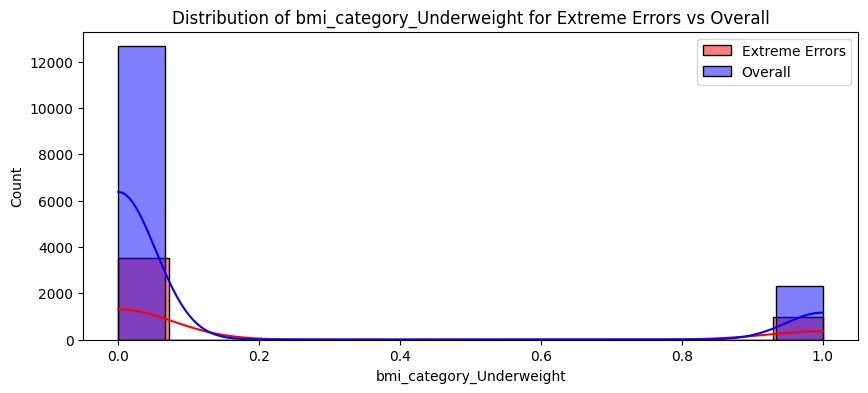

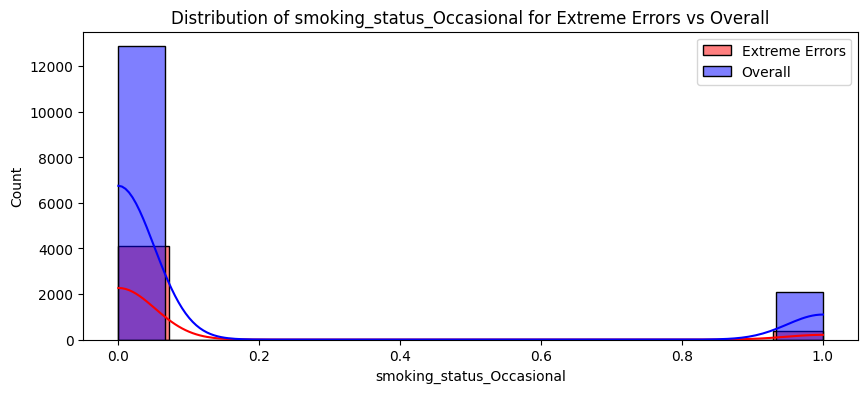

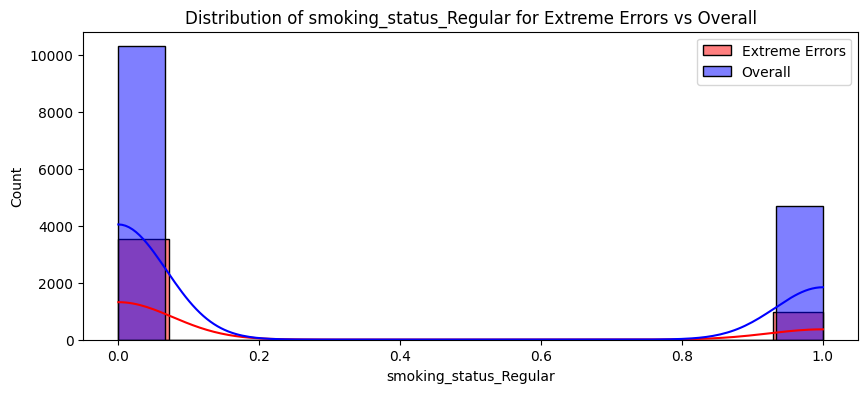

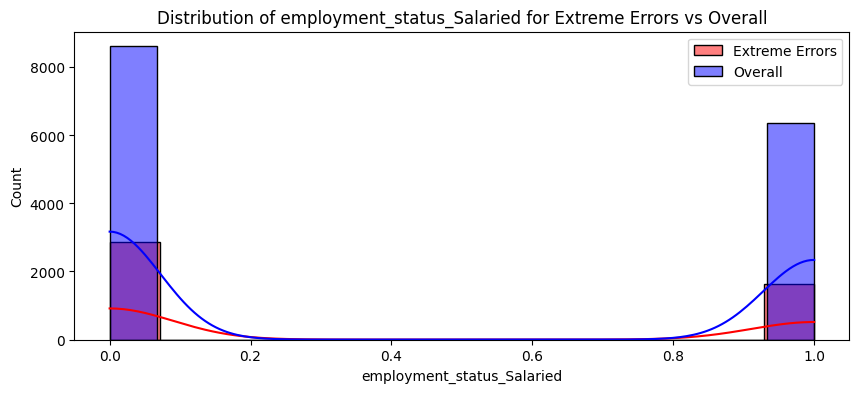

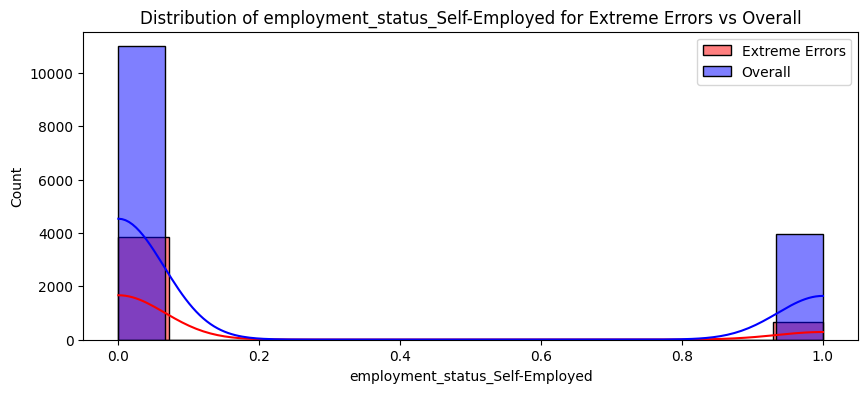

In [92]:
for feature in x_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_error_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(x_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()


### Problem in Age column

In [94]:
cols_to_scale

['age',
 'number_of_dependants',
 'income_level',
 'income_lakhs',
 'insurance_plan']

In [96]:
extreme_error_df['income_level'] = -1

<Axes: xlabel='age', ylabel='Count'>

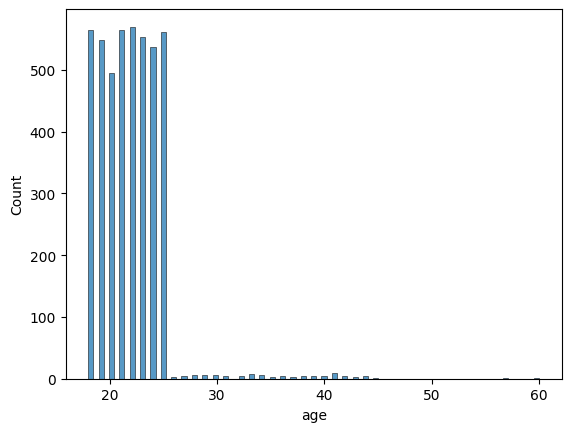

In [99]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_error_df[cols_to_scale])
df_reversed.head()
sns.histplot(df_reversed["age"])

In [105]:
### This means that 97% of age is 25 .

df_reversed["age"].quantile(0.97)

np.float64(25.0)